In [5]:
import pandas as pd
import tushare as ts
from xlib.mysql import mysql
from xlib.astock import AStock

def fcompute(ts_code,df_cal,basic):
    #获取每日行情数据
    df_price=AStock.getStockDailyPriceByCode(ts_code,db)
    df_price=pd.merge(df_cal,df_price,on=['trade_date'],how='outer', validate="one_to_many")
    
    #获取资产负债表中所有数据
    df_balance=mysql.selectToDf("select * from astock_finance_balancesheet where ts_code='"+ts_code+"' and report_type=1 order by ann_date asc",db)
    df_balance.rename(columns={'ann_date':'trade_date'}, inplace = True)
    df_balance=df_balance.drop('ts_code', axis=1)   
    df=pd.merge(df_price, df_balance, how='left', on='trade_date', copy=True, indicator=False)
    
     #获取现金流量表中所有数据
    df_cashflow=mysql.selectToDf("select * from astock_finance_cashflow where ts_code='"+ts_code+"' and report_type=1 order by ann_date asc",db)
    df_cashflow.rename(columns={'ann_date':'trade_date'}, inplace = True)
    df_cashflow=df_cashflow.drop('ts_code', axis=1)   
    df=pd.merge(df,df_cashflow, how='left', on='trade_date', copy=True, indicator=False)
    
    #获取利润表中所有数据
    df_income=mysql.selectToDf("select * from astock_finance_income where ts_code='"+ts_code+"' and report_type=1 order by ann_date asc",db)
    df_income.rename(columns={'ann_date':'trade_date'}, inplace = True)
    df_income=df_income.drop('ts_code', axis=1)   
    df=pd.merge(df, df_income, how='left', on='trade_date', copy=True, indicator=False)
    
    #获取每日指标，市值、PE等
    df_daily_basic=mysql.selectToDf("select * from astock_price_daily_basic where ts_code='"+ts_code+"' order by trade_date asc",db)
    df_daily_basic=df_daily_basic.drop('close', axis=1)   
    df_daily_basic=df_daily_basic.drop('ts_code', axis=1)   
    df=pd.merge(df, df_daily_basic, how='left', on='trade_date', copy=True, indicator=False)
    
    #格式化一下数据
    df=df.fillna(method='ffill')
    df['ts_code']=ts_code
    df['industry']=str(basic[basic['ts_code']==ts_code]['industry'].values[0])
    df=df[df.trade_date>'20150101']
    df=df[df.trade_date<'20220410']
    df=df.reset_index(drop=True)
    df.rename(columns={'ts_code':'symbol','trade_date':'date'}, inplace = True)
    df['date']=df['date'].map(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:8])
    return df



In [6]:
db="tushare"
#交易日历
df_cal=mysql.selectToDf("select cal_date as trade_date from astock_trade_cal where is_open=1",db)
df_cal=df_cal[df_cal.trade_date>'20150101']
df_cal=df_cal[df_cal.trade_date<'20220410']

#取出行业数据
basic=mysql.selectToDf("select ts_code,industry from astock_basic",db)

#找完美世界试一下
df=fcompute('002624.SZ',df_cal,basic)

#打印所有字段
print(df.columns.to_list())

['date', 'symbol', 'open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount', 'adj_factor', 'vwap', 'prev_close', 'returns', 'volume', 'f_ann_date_x', 'end_date_x', 'report_type_x', 'comp_type_x', 'end_type_x', 'total_share_x', 'cap_rese', 'undistr_porfit', 'surplus_rese', 'special_rese', 'money_cap', 'trad_asset', 'notes_receiv', 'accounts_receiv', 'oth_receiv', 'prepayment', 'div_receiv', 'int_receiv', 'inventories', 'amor_exp', 'nca_within_1y', 'sett_rsrv', 'loanto_oth_bank_fi', 'premium_receiv', 'reinsur_receiv', 'reinsur_res_receiv', 'pur_resale_fa', 'oth_cur_assets', 'total_cur_assets', 'fa_avail_for_sale', 'htm_invest', 'lt_eqt_invest', 'invest_real_estate', 'time_deposits', 'oth_assets', 'lt_rec', 'fix_assets', 'cip', 'const_materials', 'fixed_assets_disp', 'produc_bio_assets', 'oil_and_gas_assets', 'intan_assets', 'r_and_d', 'goodwill', 'lt_amor_exp', 'defer_tax_assets', 'decr_in_disbur', 'oth_nca', 'total_nca', 'cash_reser_cb', 'depos_in_oth_bfi', 'pre

In [7]:
pro = ts.pro_api()
df_code = pro.index_weight(index_code='000300.SH', start_date='20150101', end_date='20220410')
df_code.drop_duplicates(subset=['con_code'],keep='first',inplace=True)
 
df_all=[]
df_mean_all=[]
df_code=df_code['con_code'].to_list()

for ts_code in df_code:
    df=fcompute(ts_code,df_cal,basic)
    df_all.append(df)
        
    print(ts_code)

df_all=pd.concat(df_all)

df_all.to_csv("./xlib/cache/fin32.csv")

603195.SH
003816.SZ
300782.SZ
601138.SH
600989.SH
601698.SH
300750.SZ
601916.SH
002938.SZ
601319.SH
603259.SH
601236.SH
300896.SZ
601865.SH
601066.SH
300759.SZ
300760.SZ
688111.SH
601990.SH
603486.SH
002916.SZ
603392.SH
600025.SH
603659.SH
603087.SH
300677.SZ
603882.SH
603260.SH
001979.SZ
300676.SZ
603233.SH
601155.SH
300628.SZ
601108.SH
300498.SZ
300595.SZ
300601.SZ
603501.SH
002841.SZ
603833.SH
603517.SH
601881.SH
300408.SZ
300413.SZ
300558.SZ
300450.SZ
603019.SH
603658.SH
002812.SZ
603939.SH
603338.SH
601966.SH
603799.SH
300433.SZ
002821.SZ
603160.SH
603986.SH
601985.SH
300529.SZ
002791.SZ
601021.SH
603369.SH
603899.SH
000333.SZ
601808.SH
601939.SH
002179.SZ
601169.SH
603806.SH
002714.SZ
002709.SZ
601238.SH
603288.SH
603993.SH
300347.SZ
300316.SZ
601231.SH
601360.SH
002157.SZ
601800.SH
601225.SH
601100.SH
300274.SZ
601669.SH
002624.SZ
002602.SZ
002607.SZ
002600.SZ
002601.SZ
002594.SZ
002568.SZ
601216.SH
002555.SZ
601799.SH
601933.SH
601211.SH
002736.SZ
000166.SZ
300144.SZ
600919.SH


Starting training...
[1]	valid_0's l2: 0.130933
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.0938168
[3]	valid_0's l2: 0.0701575
[4]	valid_0's l2: 0.053985
[5]	valid_0's l2: 0.0438932
[6]	valid_0's l2: 0.0391372
[7]	valid_0's l2: 0.0342216
[8]	valid_0's l2: 0.0312941
[9]	valid_0's l2: 0.0290122
[10]	valid_0's l2: 0.0280949
[11]	valid_0's l2: 0.027024
[12]	valid_0's l2: 0.0262155
[13]	valid_0's l2: 0.0259196
[14]	valid_0's l2: 0.0256977
[15]	valid_0's l2: 0.0253742
[16]	valid_0's l2: 0.025212
[17]	valid_0's l2: 0.0251388
[18]	valid_0's l2: 0.0251333
[19]	valid_0's l2: 0.0250896
[20]	valid_0's l2: 0.0248892
[21]	valid_0's l2: 0.0248553
[22]	valid_0's l2: 0.0248123
[23]	valid_0's l2: 0.02481
[24]	valid_0's l2: 0.0247886
[25]	valid_0's l2: 0.0247066
[26]	valid_0's l2: 0.0246714
[27]	valid_0's l2: 0.0245825
[28]	valid_0's l2: 0.0245327
[29]	valid_0's l2: 0.0245359
[30]	valid_0's l2: 0.0244667
[31]	valid_0's l2: 0.0244985
[32]	valid_0's l2: 0.0244444
[33]	v

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-01-02  2018-01-02
End Period                 2022-04-08  2022-04-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          16.97%      -2.82%
CAGR﹪                     3.74%       -0.67%

Sharpe                     0.32        0.07
Smart Sharpe               0.32        0.07
Sortino                    0.48        0.11
Smart Sortino              0.48        0.1
Sortino/√2                 0.34        0.07
Smart Sortino/√2           0.34        0.07
Omega                      1.06        1.06

Max Drawdown               -24.02%     -48.95%
Longest DD Days            763         1190
Volatility (ann.)          15.37%      20.98%
R^2                        0.43        0.43
Calmar                     0.16        -0.01
Skew                       0.26        0.51
Kurtosis                   4.38        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-06,2022-03-15,2022-04-08,763,-24.019283,-22.095812
2,2018-07-04,2018-10-18,2019-02-25,236,-17.674367,-16.032409
3,2019-04-02,2019-08-09,2019-12-19,261,-11.454551,-10.680267
4,2020-01-21,2020-02-03,2020-02-13,23,-7.312058,-6.913097
5,2018-03-13,2018-03-23,2018-05-09,57,-5.123676,-4.048202


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


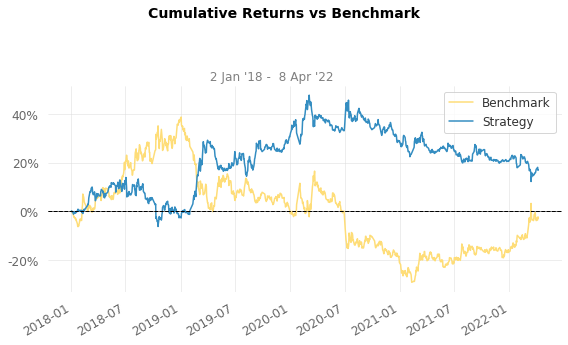

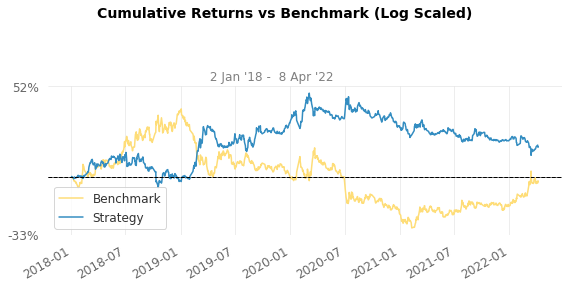

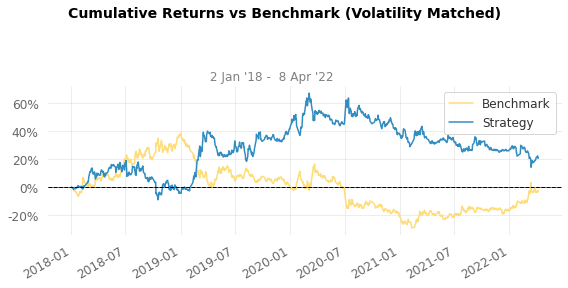

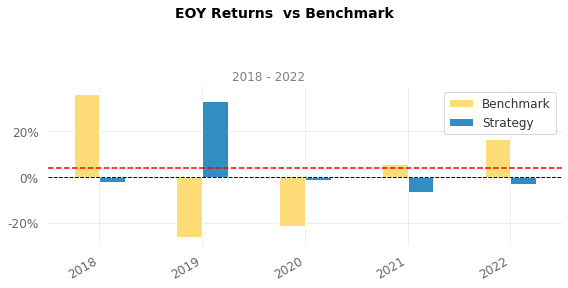

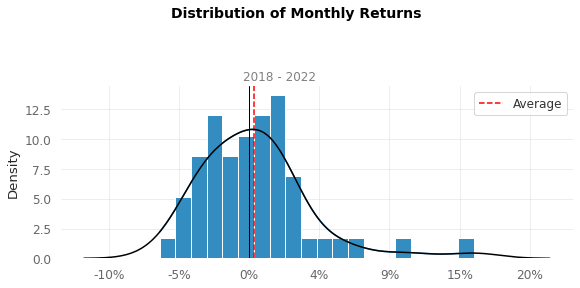

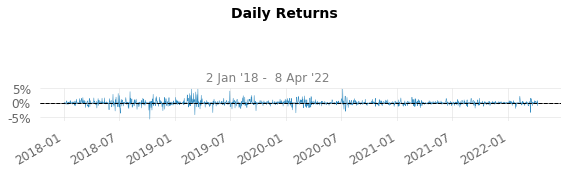

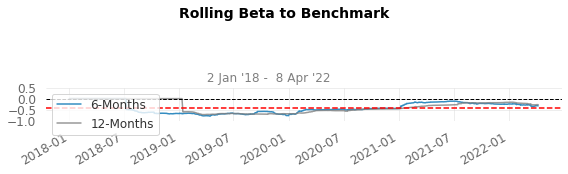

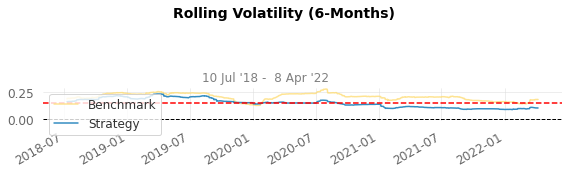

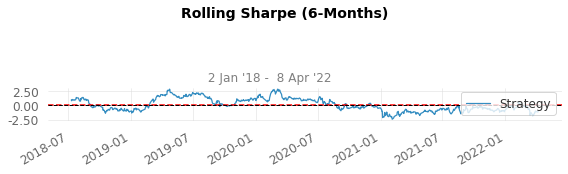

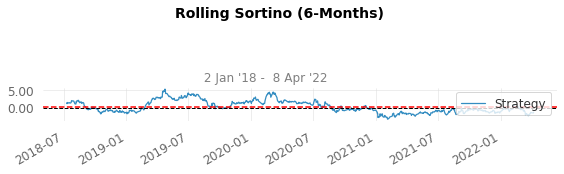

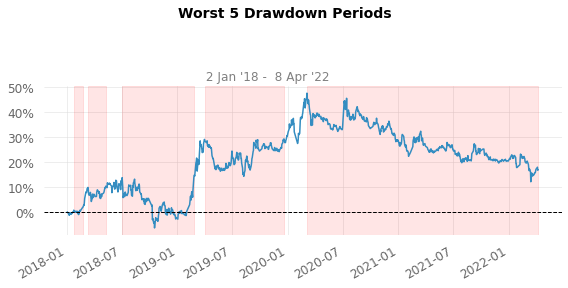

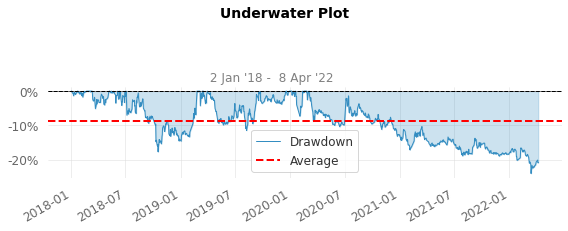

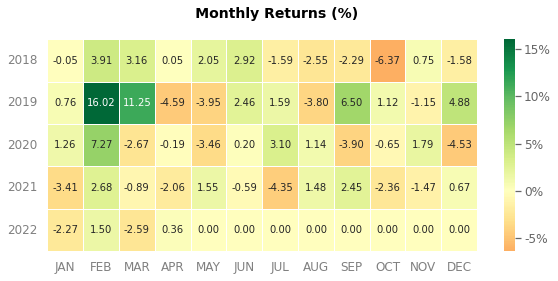

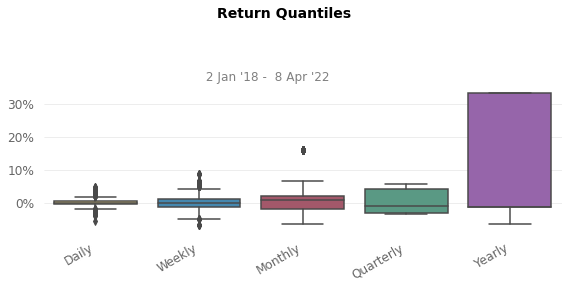

In [2]:
import pandas as pd
from xlib import data
import akshare as ak

idx_data = ak.index_zh_a_hist(symbol='000300', period="daily", start_date='20180101', end_date='20220410')    
idx_data.rename(columns={'日期':'date', '开盘':'open', '收盘':'close', 
                           '最高':'high', '最低':'low', '成交量':'volume',
                           '成交额':'amount', '振幅':'swing', '涨跌幅':'chg_pct',
                           '涨跌额':'chg_amount', '换手率':'turnover',
                          }, inplace = True)
idx_data['date'] = pd.to_datetime(idx_data['date'], format='%Y-%m-%d')
bench=idx_data.set_index('date')

df=pd.DataFrame()
df=pd.read_csv('./xlib/cache/fin32.csv',index_col=0)
df=df.reset_index(drop=True)
df.rename(columns={'close_x':'close'}, inplace = True)
df['label']=df['close'].shift(-30)/df['close']


df['industry']=pd.factorize(df["industry"])[0].astype(int)

from xlib import model
df_train,df_valid,df_pred=model.datasplit(df,train_end='2017-01-01',valid_end='2018-01-01')
model.lgbtrain(df_train,df_valid,label='label')  
preds=model.lgbpred(df_pred,label='label') 

from xlib.strategies import Top10Strategy
from xlib import backtest
preds['score']=preds.apply(lambda x: -9 if x['high']==x['low'] else x['pred'] ,axis=1)
preds['rank']=preds.groupby('date')['score'].rank(method='max',ascending=False)
preds['signal']=preds.apply(lambda x: 1 if x['rank']<=10 else 0 ,axis=1)


returns=backtest.test(preds,Top10Strategy,hold_day=30)
preds=preds[preds.signal==1]
preds.to_csv("./xlib/cache/preds32.csv")

backtest.analysis(returns,bench)

In [5]:
print(len(df.columns.to_list()))

361
